## Homework 2

by Masha Golubeva

First of all, here is the function that tranforms a plain text so that every sentence was a separate line. I will create my database and work further with the same text as before, "WELCOME TO THE WORLD, BABY GIRL" by Fannie Flagg (Russian translation)

In [178]:
def TextinLines(filename):
    with open(filename, "r", encoding="utf-8") as file:
        text=file.read() 

    text_listed=[]
    for i in text.split():
        text_listed.append(i)
        if i.endswith(('.','!','?','...')) and len(i)>2:
            text_listed.append('\n')

    text_lined=' '.join(text_listed)
    with open("TextinLines.txt", "w",encoding='utf-8') as file:
        file.write(text_lined)

In [179]:
TextinLines('Welcome.txt')

At first, I divide the text into sentences, and the first table in my database, "Sentences", includes sentences and their index number

In [31]:
import sqlite3
import string

In [249]:
conn = sqlite3.connect('BabyGirl1.db')
c = conn.cursor()
c.execute("CREATE TABLE IF NOT EXISTS Sentences(number INTEGER, sentence_text TEXT)")

with open('TextinLines.txt', "r", encoding="utf-8") as file:
    text=file.read()

i=1
for line in text.split('\n'):
    c.execute("INSERT INTO Sentences VALUES (?, ?)", (i, line.strip()))
    i+=1
    
conn.commit()

In [250]:
for row in c.execute('SELECT * FROM Sentences LIMIT 10'):
    print(row)

(1, '«…Бедные маленькие человеческие создания – они оказались втянуты в этот мир, не имея представления, откуда взялись, что должны делать и долго ли им придется этим заниматься.')
(2, 'И чем это все закончится.')
(3, 'Но большинство из них, слава богу, каждое утро просыпаются и стараются найти во всем этом какой-то смысл.')
(4, 'Просто невозможно не любить их, правда?')
(5, 'Удивляет меня только, как они умудряются не все свихнуться».')
(6, 'Тетя Элнер, 1978 Пролог Элмвуд-Спрингс, штат Миссури 1948 В конце сороковых годов Элмвуд-Спрингс, расположенный на юге штата Миссури, ничем примечательным не выделяется среди тысяч маленьких городков, разбросанных по Америке.')
(7, 'Центр города состоит из улицы длиной в квартал, с аптекой «Рексалл» в одном ее конце и Масонской ложей Элмвуд-Спрингс в другом.')
(8, 'Давайте прогуляемся от Масонской ложи к аптеке – мимо химчистки «Голубая лента», обувной мастерской «Кошачья лапка» с розовым неоновым ботинком в окне, универмага братьев Морган, мимо б

The second table "Words" includes all wordforms, their index number and sentences they belong to

In [222]:
c.execute("CREATE TABLE IF NOT EXISTS Words(sent TEXT, word TEXT, word_id INTEGER)")

This code did not work for some reason, it only added to the "Words" table words from the first sentence, but not from all other sentences

In [66]:
punct = string.punctuation+'–'+'«'+'»'+'…'
for row in c.execute('SELECT * FROM Sentences'):
    for w in row[1].split(' '):
        c.execute("INSERT INTO Words VALUES (?, ?)", (row[0],w.strip(punct)))
        conn.commit()

(1, 'Но если, истончившись, оболочка Раздувшегося вымысла нам явит Реальность под собой - что мы увидим?')


So, I had to create a special dictionary first, move all the data from the first table there and then insert in in "Words" table. It is strange, because it doesn't make sence to work with tables instead of dictionaries

In [223]:
punct = string.punctuation+'–'+'«'+'»'+'…'

sents=[]
for row in c.execute('SELECT * FROM Sentences'):
    sents.append(row[1])

i=1
for s in sents:
    for w in s.split(' '):
        if w.strip(punct).isalnum():
            c.execute("INSERT INTO Words VALUES (?, ?, ?)", (s, w.strip(punct), i))
            i+=1
conn.commit()

In [220]:
''.isalnum()

False

In [224]:
for row in c.execute('SELECT * FROM Words LIMIT 10'):
    print(row)

('«…Бедные маленькие человеческие создания – они оказались втянуты в этот мир, не имея представления, откуда взялись, что должны делать и долго ли им придется этим заниматься.', 'Бедные', 1)
('«…Бедные маленькие человеческие создания – они оказались втянуты в этот мир, не имея представления, откуда взялись, что должны делать и долго ли им придется этим заниматься.', 'маленькие', 2)
('«…Бедные маленькие человеческие создания – они оказались втянуты в этот мир, не имея представления, откуда взялись, что должны делать и долго ли им придется этим заниматься.', 'человеческие', 3)
('«…Бедные маленькие человеческие создания – они оказались втянуты в этот мир, не имея представления, откуда взялись, что должны делать и долго ли им придется этим заниматься.', 'создания', 4)
('«…Бедные маленькие человеческие создания – они оказались втянуты в этот мир, не имея представления, откуда взялись, что должны делать и долго ли им придется этим заниматься.', 'они', 5)
('«…Бедные маленькие человеческие соз

The third table is called "Morphology" and includes the wordform, its index number, part of speech and the normal form  

In [187]:
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

In [233]:
c.execute("CREATE TABLE IF NOT EXISTS Morphology(Wordform_m TEXT, word_index INTEGER, Lemma TEXT, POS TEXT, Morph_info TEXT)")
i=1
for s in sents:
    for w in s.split(' '):
        ana=morph.parse(w.strip(punct))[0]
        if w.strip(punct).isalnum():
            c.execute("INSERT INTO Morphology VALUES (?, ?, ?, ?, ?)", (w.strip(punct), i, ana.normal_form, ana.tag.POS, str(ana.tag)))
            i+=1
conn.commit()

In [234]:
for row in c.execute('SELECT * FROM Morphology LIMIT 10 OFFSET 22'):
    print(row)

('придется', 23, 'прийтись', 'VERB', 'VERB,perf,intr sing,3per,futr,indc')
('этим', 24, 'это', 'NPRO', 'NPRO,neut sing,ablt')
('заниматься', 25, 'заниматься', 'INFN', 'INFN,impf,intr')
('И', 26, 'и', 'CONJ', 'CONJ')
('чем', 27, 'чем', 'CONJ', 'CONJ')
('это', 28, 'это', 'PRCL', 'PRCL')
('все', 29, 'всё', 'PRCL', 'PRCL')
('закончится', 30, 'закончиться', 'VERB', 'VERB,perf,intr sing,3per,futr,indc')
('Но', 31, 'но', 'CONJ', 'CONJ')
('большинство', 32, 'большинство', 'NOUN', 'NOUN,inan,neut,Sgtm sing,nomn')


Also, I will include the "Syntax" table in the database, which consists of sentences, words, the relations these words are bound by and the head of this relation. Honestly, it doesn't make much sence, as the syntactic parsing doesn't work very well for Russian, but let's include this information in the database to make it more complete

In [190]:
import spacy
from spacy import displacy
nlp = spacy.load("ru_core_news_sm")

In [191]:
c.execute("CREATE TABLE IF NOT EXISTS Syntax(Sentence TEXT, Wordform TEXT, Relation TEXT, Head TEXT)")
for s in sents:
    d=nlp(s)
    for w in d:
        if w.text.isalnum():
            c.execute("INSERT INTO Syntax VALUES (?, ?, ?, ?)", (s, w.text, w.dep_, w.head.text))
conn.commit()  

In [192]:
for row in c.execute('SELECT * FROM Syntax LIMIT 10'):
    print(row)

('«…Бедные маленькие человеческие создания – они оказались втянуты в этот мир, не имея представления, откуда взялись, что должны делать и долго ли им придется этим заниматься.', 'Бедные', 'amod', 'создания')
('«…Бедные маленькие человеческие создания – они оказались втянуты в этот мир, не имея представления, откуда взялись, что должны делать и долго ли им придется этим заниматься.', 'маленькие', 'amod', 'создания')
('«…Бедные маленькие человеческие создания – они оказались втянуты в этот мир, не имея представления, откуда взялись, что должны делать и долго ли им придется этим заниматься.', 'человеческие', 'amod', 'создания')
('«…Бедные маленькие человеческие создания – они оказались втянуты в этот мир, не имея представления, откуда взялись, что должны делать и долго ли им придется этим заниматься.', 'создания', 'nsubj', 'оказались')
('«…Бедные маленькие человеческие создания – они оказались втянуты в этот мир, не имея представления, откуда взялись, что должны делать и долго ли им приде

So, here is how we can create dataframes from the database:

In [193]:
import pandas as pd

For example, I would like just to see what is inside my "Syntax" table. I print the fisrt 15 rows

In [284]:
pd.read_sql_query('SELECT * FROM Syntax LIMIT 20', con=conn)

,Sentence,Wordform,Relation,Head
0,«…Бедные маленькие человеческие создания – они...,Бедные,amod,создания
1,«…Бедные маленькие человеческие создания – они...,маленькие,amod,создания
2,«…Бедные маленькие человеческие создания – они...,человеческие,amod,создания
3,«…Бедные маленькие человеческие создания – они...,создания,nsubj,оказались
4,«…Бедные маленькие человеческие создания – они...,они,nsubj,оказались
5,«…Бедные маленькие человеческие создания – они...,оказались,ROOT,оказались
6,«…Бедные маленькие человеческие создания – они...,втянуты,xcomp,оказались
7,«…Бедные маленькие человеческие создания – они...,в,case,мир
8,«…Бедные маленькие человеческие создания – они...,этот,det,мир
9,«…Бедные маленькие человеческие создания – они...,мир,obl,втянуты


It contains information about sentence of each word, the head this word depends on and the type of relation. 

Maybe I would like to get the information about a particular sentence, and I know its number. I can do the following:

In [286]:
pd.read_sql_query('SELECT Sentence, Wordform, Relation, Head, number FROM Syntax JOIN Sentences ON Sentence=sentence_text WHERE number=1 LIMIT 10', con=conn)

,Sentence,Wordform,Relation,Head,number
0,«…Бедные маленькие человеческие создания – они...,Бедные,amod,создания,1
1,«…Бедные маленькие человеческие создания – они...,в,case,мир,1
2,«…Бедные маленькие человеческие создания – они...,взялись,acl:relcl,представления,1
3,«…Бедные маленькие человеческие создания – они...,втянуты,xcomp,оказались,1
4,«…Бедные маленькие человеческие создания – они...,делать,xcomp,должны,1
5,«…Бедные маленькие человеческие создания – они...,долго,advmod,придется,1
6,«…Бедные маленькие человеческие создания – они...,должны,ccomp,взялись,1
7,«…Бедные маленькие человеческие создания – они...,заниматься,csubj,придется,1
8,«…Бедные маленькие человеческие создания – они...,и,cc,придется,1
9,«…Бедные маленькие человеческие создания – они...,им,iobj,придется,1


For some reason, the wordforms changed their order here (no idea why really). But I created another table, "Words", where all the wordforms were numbere by the order they were in the text. I could use it here to put them back in order. Here I try to do it:

In [307]:
pd.read_sql_query('''SELECT DISTINCT Sentence, Wordform, word_id, Relation, Head, number FROM Syntax 
                        JOIN Sentences ON Sentence=sentence_text 
                        JOIN Words ON Wordform=word WHERE number=1 ORDER BY word_id LIMIT 20''', con=conn)

,Sentence,Wordform,word_id,Relation,Head,number
0,«…Бедные маленькие человеческие создания – они...,Бедные,1,amod,создания,1
1,«…Бедные маленькие человеческие создания – они...,маленькие,2,amod,создания,1
2,«…Бедные маленькие человеческие создания – они...,человеческие,3,amod,создания,1
3,«…Бедные маленькие человеческие создания – они...,создания,4,nsubj,оказались,1
4,«…Бедные маленькие человеческие создания – они...,они,5,nsubj,оказались,1
5,«…Бедные маленькие человеческие создания – они...,оказались,6,ROOT,оказались,1
6,«…Бедные маленькие человеческие создания – они...,втянуты,7,xcomp,оказались,1
7,«…Бедные маленькие человеческие создания – они...,в,8,case,мир,1
8,«…Бедные маленькие человеческие создания – они...,этот,9,det,мир,1
9,«…Бедные маленькие человеческие создания – они...,мир,10,obl,втянуты,1


And it seems okay, unless we put the LIMIT off:...

In [308]:
pd.read_sql_query('''SELECT DISTINCT Sentence, Wordform, word_id, Relation, Head, number FROM Syntax 
                        JOIN Sentences ON Sentence=sentence_text 
                        JOIN Words ON Wordform=word WHERE number=1 ORDER BY word_id''', con=conn)

,Sentence,Wordform,word_id,Relation,Head,number
0,«…Бедные маленькие человеческие создания – они...,Бедные,1,amod,создания,1
1,«…Бедные маленькие человеческие создания – они...,маленькие,2,amod,создания,1
2,«…Бедные маленькие человеческие создания – они...,человеческие,3,amod,создания,1
3,«…Бедные маленькие человеческие создания – они...,создания,4,nsubj,оказались,1
4,«…Бедные маленькие человеческие создания – они...,они,5,nsubj,оказались,1
...,...,...,...,...,...,...
2818,«…Бедные маленькие человеческие создания – они...,и,27625,cc,придется,1
2819,«…Бедные маленькие человеческие создания – они...,и,27639,cc,придется,1
2820,«…Бедные маленькие человеческие создания – они...,и,27654,cc,придется,1
2821,«…Бедные маленькие человеческие создания – они...,и,27664,cc,придется,1


I have really no idea, why do I get 2823 words in ONE FIRST SENTENCE... I guess, I don't undestand completely how the database should work

Now I will go further and try to add morphological info in my table:

In [314]:
pd.read_sql_query('''SELECT DISTINCT Sentence, Wordform, word_id, Relation, Head, POS, Lemma, number FROM Syntax 
                        JOIN Sentences ON Sentence=sentence_text 
                        JOIN Words ON Wordform=word 
                        JOIN Morphology ON word_id=word_index WHERE number=1 ORDER BY word_id LIMIT 20''', con=conn)

,Sentence,Wordform,word_id,Relation,Head,POS,Lemma,number
0,«…Бедные маленькие человеческие создания – они...,Бедные,1,amod,создания,NOUN,бедный,1
1,«…Бедные маленькие человеческие создания – они...,маленькие,2,amod,создания,ADJF,маленький,1
2,«…Бедные маленькие человеческие создания – они...,человеческие,3,amod,создания,ADJF,человеческий,1
3,«…Бедные маленькие человеческие создания – они...,создания,4,nsubj,оказались,NOUN,создание,1
4,«…Бедные маленькие человеческие создания – они...,они,5,nsubj,оказались,NPRO,они,1
5,«…Бедные маленькие человеческие создания – они...,оказались,6,ROOT,оказались,VERB,оказаться,1
6,«…Бедные маленькие человеческие создания – они...,втянуты,7,xcomp,оказались,ADJS,втянутый,1
7,«…Бедные маленькие человеческие создания – они...,в,8,case,мир,PREP,в,1
8,«…Бедные маленькие человеческие создания – они...,этот,9,det,мир,ADJF,этот,1
9,«…Бедные маленькие человеческие создания – они...,мир,10,obl,втянуты,NOUN,мир,1


Well, it seems okay again, unless we try out something else except the very first sentence..

In [315]:
pd.read_sql_query('''SELECT DISTINCT Sentence, Wordform, word_id, Relation, Head, POS, Lemma, number FROM Syntax 
                        JOIN Sentences ON Sentence=sentence_text 
                        JOIN Words ON Wordform=word 
                        JOIN Morphology ON word_id=word_index WHERE number=7 ORDER BY word_id LIMIT 20''', con=conn)

,Sentence,Wordform,word_id,Relation,Head,POS,Lemma,number
0,Центр города состоит из улицы длиной в квартал...,в,8,case,другом,PREP,в,7
1,Центр города состоит из улицы длиной в квартал...,в,8,case,квартал,PREP,в,7
2,Центр города состоит из улицы длиной в квартал...,в,8,case,конце,PREP,в,7
3,Центр города состоит из улицы длиной в квартал...,и,19,cc,ложей,CONJ,и,7
4,Центр города состоит из улицы длиной в квартал...,из,33,case,улицы,PREP,из,7
5,Центр города состоит из улицы длиной в квартал...,и,40,cc,ложей,CONJ,и,7
6,Центр города состоит из улицы длиной в квартал...,конце,70,obl,состоит,NOUN,конец,7
7,Центр города состоит из улицы длиной в квартал...,Центр,89,nsubj,состоит,NOUN,центр,7
8,Центр города состоит из улицы длиной в квартал...,города,90,nmod,Центр,NOUN,город,7
9,Центр города состоит из улицы длиной в квартал...,состоит,91,ROOT,состоит,VERB,состоять,7


Why are my prepositions doubled.... I don't understand, it is not even a trained model, this is supposed to be working predictably..

Okay, here is some crazy visualisation of my crazy database. For example, below you can find the barplot with numbers of different relations in the text I parsed. I don't even know if I can trust it or not, but if I use just one of the tables I probably can

In [317]:
s=pd.read_sql_query('SELECT * FROM Syntax', con=conn)

In [319]:
import matplotlib.pyplot as plt

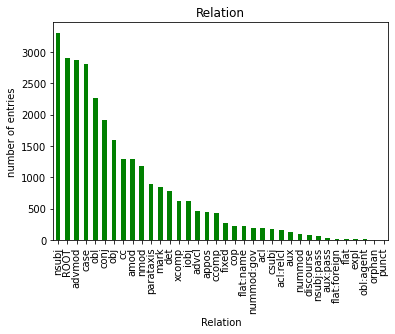

In [320]:
s['Relation'].value_counts().plot.bar(color='green');
plt.title('Relation')
plt.xlabel('Relation')
plt.ylabel('number of entries');

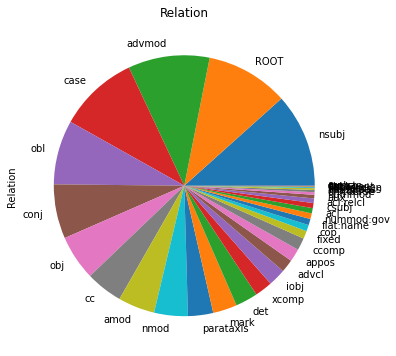

In [332]:
plt.figure(figsize=(6, 6))
s['Relation'].value_counts().plot(kind='pie');
plt.title('Relation');

And that's how we can see how the parts of speech are distributed in the text

In [323]:
s2=pd.read_sql_query('SELECT * FROM Morphology', con=conn)

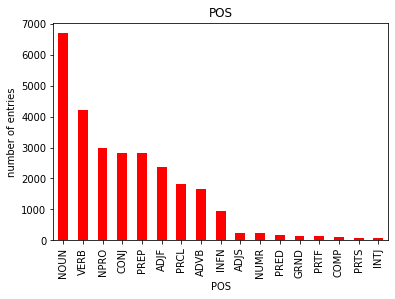

In [334]:
s2['POS'].value_counts().plot.bar(color='red');
plt.title('POS')
plt.xlabel('POS')
plt.ylabel('number of entries');

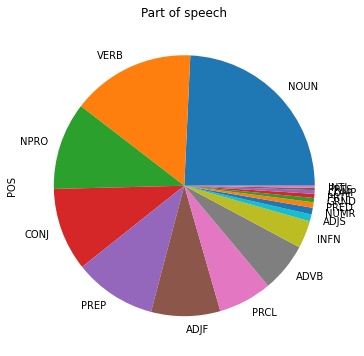

In [324]:
plt.figure(figsize=(6, 6))
s2['POS'].value_counts().plot(kind='pie');
plt.title('Part of speech');

That's what I was able to create. Sorry..